In [1]:
# This script is built. as a working POC for an ab test analyser
# The specific purpose for this can be split into a few areas
# 1. Handle existing user test (not new users)
# 2. Add more metrics
# 3. Be able to zoom in on subgroups of (engaged) users
# 4. Provide group size estimates and verify that these works

# Data is fetched via Pandas Bigquery connector
# Data is analyzed with bootstrapping
# Up to 4 groups are allowed in this version (although this could easily be expanded if needed)


In [2]:
import pandas_gbq
import pydata_google_auth
import numpy as np
import random as rnd
import matplotlib.pyplot as plt


In [3]:
# In this cell we make all the necessary settings for running the test

# SQL to fetch the data
#sql = "SELECT  * FROM `maginteractive-se-analytics.magnus_dataset.v_nqd_ab_test_data_newuseradfree_202205` "
sql = "SELECT  * FROM `maginteractive-se-analytics.magnus_dataset.v_wz_ab_test_data_interstitial_placement_202205` "

# Generic columns available:
# inapp_spend, purchases, purchaser, playdays, ad_views, ad_views_per_day, 
# ad_revenue, ad_revenue_arpdau, revenue, arpdau

# Additional columns in this dataset: v_nqd_ab_test_data_newuseradfree_202205
# purchases_remove_ads_30, 

# Additional columns in this dataset: v_wz_ab_test_data_interstitial_placement_202205
# paidswaps, games_started, games_finished


analyse_group = "all"
#analyse_group = "engaged"

engagement_metric = "purchases"
engagement_threshold = 0
select_metric = "games_finished" 

truncate = 0

# Use this together with Cell --> Run all to avoid loading the same data over and over again
fetch_new_data = True
#fetch_new_data = False

# Basic parameters for determining group size
power = 2 # multiples of std dev
effect = 0.20 # in % of base mean

# Set number of bootstrap rounds
# This number is not critical, it just needs to be large enough to produce a relevant distribution of results
bs_rounds = 20000

#divided into
chunks = 10


In [4]:
# Fetch data from big query
# Key data is ab test group and the metric
if fetch_new_data:
    SCOPES = [
        'https://www.googleapis.com/auth/cloud-platform',
        'https://www.googleapis.com/auth/drive',
    ]

    credentials = pydata_google_auth.get_user_credentials(
        SCOPES,
        # Set auth_local_webserver to True to have a slightly more convienient
        # authorization flow. Note, this doesn't work if you're running from a
        # notebook on a remote sever, such as over SSH or with Google Colab.
        auth_local_webserver=True,
        # Use the NOOP cache to avoid writing credentials to disk.
        #cache=pydata_google_auth.cache.NOOP,
    )

    print('Reading data...')
    raw_data = pandas_gbq.read_gbq(sql, project_id='maginteractive-se-analytics', credentials=credentials, dialect="standard")

Reading data...


Downloading: 100%|█████████████████████████████████████████████████████████████████████| 18000/18000 [00:04<00:00, 3646.92rows/s]


In [5]:
# Check that data looks ok
print('Raw data:',raw_data[1:5])

Raw data:         userid      min_dt  ab_group  purchaser  purchases  playdays  \
1  24977989663  2022-05-18         2          1         59        16   
2  25140297923  2022-05-18         0          1         57        16   
3  25280597682  2022-05-18         1          1         56        15   
4  25440698571  2022-05-18         0          1         54        14   

   inapp_spend  ad_views  ad_revenue  ad_views_per_day  ad_revenue_arpdau  \
1   294.410000     202.0    2.284321         12.625000           0.142770   
2   190.759264      90.0    2.086735          5.625000           0.130421   
3   135.440000     266.0   38.000685         17.733333           2.533379   
4   240.169155     285.0    1.757666         20.357143           0.125548   

      revenue     arpdau  collectiontoast  games_started  games_finished  \
1  296.694321  18.543395                0            441             115   
2  192.845999  12.052875                2           1712             556   
3  173.440685  

In [6]:
# Extract the ab test groups from the data and put into numpy arrays
# Use the selected engagement metric and measred metric and convert to numpy for further processing

group0_all = raw_data.loc[:,[engagement_metric, select_metric]][raw_data.ab_group == 0].to_numpy()
group1_all = raw_data.loc[:,[engagement_metric, select_metric]][raw_data.ab_group == 1].to_numpy()
group2_all = raw_data.loc[:,[engagement_metric, select_metric]][raw_data.ab_group == 2].to_numpy()
group3_all = raw_data.loc[:,[engagement_metric, select_metric]][raw_data.ab_group == 3].to_numpy()

print('Group 0 data:',group0_all[1:5])
print('Group 1 data:',group1_all[1:5])
print('Group 2 data:',group2_all[1:5])
print('Group 3 data:',group3_all[1:5])


Group 0 data: [[57 556]
 [54 913]
 [40 260]
 [35 146]]
Group 1 data: [[52 203]
 [45 100]
 [29 405]
 [29 34]]
Group 2 data: [[53 397]
 [52 128]
 [43 52]
 [41 240]]
Group 3 data: []


In [7]:
# Extract the engaged users into new arrays
# Use the selected threshold to break out these users from all users

group0_engaged = group0_all[group0_all[:,0] > engagement_threshold]
group1_engaged = group1_all[group1_all[:,0] > engagement_threshold]
group2_engaged = group2_all[group2_all[:,0] > engagement_threshold]
group3_engaged = group3_all[group3_all[:,0] > engagement_threshold]

print('Group 0 data:',group0_engaged[1:5])
print('Group 1 data:',group1_engaged[1:5])
print('Group 2 data:',group2_engaged[1:5])
print('Group 3 data:',group3_engaged[1:5])


Group 0 data: [[57 556]
 [54 913]
 [40 260]
 [35 146]]
Group 1 data: [[52 203]
 [45 100]
 [29 405]
 [29 34]]
Group 2 data: [[53 397]
 [52 128]
 [43 52]
 [41 240]]
Group 3 data: []


In [8]:
# Extract the size of each group as they may be different
n0_all = np.size(group0_all[truncate:-1,0])
n1_all = np.size(group1_all[truncate:-1,0])
n2_all = np.size(group2_all[truncate:-1,0])
n3_all = np.size(group3_all[truncate:-1,0])

# And the size of the engaged user groups
n0_engaged = np.size(group0_engaged[truncate:-1,0])
n1_engaged = np.size(group1_engaged[truncate:-1,0])
n2_engaged = np.size(group2_engaged[truncate:-1,0])
n3_engaged = np.size(group3_engaged[truncate:-1,0])

# Print number of users and engaged per group
print(n0_all, n1_all, n2_all, n3_all)
print(n0_engaged, n1_engaged, n2_engaged, n3_engaged)


5976 6015 6006 0
404 433 364 0


In [9]:
# Print quick check of each group data
print("Full groups:")
print('group0:',group0_all[1:5])
print('group1:',group1_all[1:5])
print('group2:',group2_all[1:5])
print('group3:',group3_all[1:5])

# Print quick check of each group data
print("Groups with engaged users only:")
print('group0:',group0_engaged[1:5])
print('group1:',group1_engaged[1:5])
print('group2:',group2_engaged[1:5])
print('group3:',group3_engaged[1:5])

# Select which groups to analuse, "all" or "engaged"
if analyse_group == "engaged":
    group0 = group0_engaged
    group1 = group1_engaged
    group2 = group2_engaged
    group3 = group3_engaged
else:
    group0 = group0_all
    group1 = group1_all
    group2 = group2_all
    group3 = group3_all

group0 = group0[truncate:-1]
group1 = group1[truncate:-1]
group2 = group2[truncate:-1]
group3 = group3[truncate:-1]

n0 = np.count_nonzero(group0[:,0])
n1 = np.count_nonzero(group1[:,0])
n2 = np.count_nonzero(group2[:,0])
n3 = np.count_nonzero(group3[:,0])

    
# Calculate the engagement rates for each group
group0_eng_rate = n0_engaged / n0_all
group1_eng_rate = n2_engaged / n1_all
if n2_all > 0: group2_eng_rate = n2_engaged / n2_all
else: 0
if n3_all > 0: group3_eng_rate = n3_engaged / n3_all 
else: 0

print("Engagement rates: ", group0_eng_rate, group1_eng_rate) #, group2_eng_rate, group3_eng_rate)

# Base data mean
mean0 = np.mean(group0[:,1])
mean1 = np.mean(group1[:,1])
mean2 = np.mean(group2[:,1])
mean3 = np.mean(group3[:,1])

# Print the theoretical CLT variances based 
print("Group size: ", n0, n1, n2, n3)
print("Group means: ", round(mean0,3), round(mean1, 3), round(mean2, 3), round(mean3, 3))

# Reset all variance
var0, var1, var2, var3 = (0,0,0,0)
var01, var02, var03, var12, var13, var23 = (0,0,0,0,0,0)

# Base data variance
var0 = np.var(group0[:,1])
var1 = np.var(group1[:,1])
if n2 > 0: var2 = np.var(group2[:,1])
if n3 > 0: var3 = np.var(group3[:,1])

# Standard deviations for each group
stdev0 = np.sqrt(var0)
stdev1 = np.sqrt(var1)
stdev2 = np.sqrt(var2)
stdev3 = np.sqrt(var3)

print("Group variances: ", round(var0,3), round(var1, 3), round(var2, 3), round(var3, 3))
print("Group std dev: ", round(stdev0,3), round(stdev1, 3), round(stdev2, 3), round(stdev3, 3))

print("Group sums: ", round(np.sum(group0[:,1]),3), round(np.sum(group1[:,1]),3), round(np.sum(group2[:,1]),3), round(np.sum(group3[:,1]),3))




Full groups:
group0: [[57 556]
 [54 913]
 [40 260]
 [35 146]]
group1: [[52 203]
 [45 100]
 [29 405]
 [29 34]]
group2: [[53 397]
 [52 128]
 [43 52]
 [41 240]]
group3: []
Groups with engaged users only:
group0: [[57 556]
 [54 913]
 [40 260]
 [35 146]]
group1: [[52 203]
 [45 100]
 [29 405]
 [29 34]]
group2: [[53 397]
 [52 128]
 [43 52]
 [41 240]]
group3: []
Engagement rates:  0.06760374832663989 0.06051537822111388
Group size:  405 434 365 0
Group means:  77.167 71.334 73.233 nan
Group variances:  11756.097 9620.341 10219.841 0
Group std dev:  108.426 98.083 101.093 0.0
Group sums:  461148 429072 439837 0


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount


In [10]:
print(group3)

[]


In [11]:
group1

array([[56, 133],
       [52, 203],
       [45, 100],
       ...,
       [0, 2],
       [0, 0],
       [0, 2]], dtype=object)

In [12]:
p=9
print(np.count_nonzero(group0[group0 == p]))
print(np.count_nonzero(group1[group1 == p]))
print(np.count_nonzero(group2[group2 == p]))
print(np.count_nonzero(group3[group3 == p]))

86
77
87
0


In [13]:
# Calculate the bootstraop mean diff variance
#var0 = np.var(group0[:,1])
#var1 = np.var(group1[:,1])
#if n2_all > 0: var2 = np.var(group2[:,1])
#if n3_all > 0: var3 = np.var(group3[:,1])

# Calculate theoretical bootstrap statistics
bs_meandiff_var01 = var0/n0 + var1/n1
bs_meandiff_stdev01 = np.sqrt(bs_meandiff_var01)

print("Mean diff var/stdev: ", bs_meandiff_var01, bs_meandiff_stdev01)

Mean diff var/stdev:  51.194085316834716 7.155004215011667


In [14]:
# Calculate resolve power (90%)
res_pwr = power * bs_meandiff_stdev01
print("Resolve power: ", res_pwr)


Resolve power:  14.310008430023334


In [15]:
# Calculate needed group size
std0 = np.sqrt(var0)
print("Group zero mean: ", mean0)
print("Group zero variance: ", var0)

group_size_needed = 2 * (power * std0 / effect /  mean0) ** 2
print("Group size needed: ", group_size_needed)
print(power, var0, effect, mean0)


Group zero mean:  77.16666666666667
Group zero variance:  11756.097054886486
Group size needed:  394.85139546848046
2 11756.097054886486 0.2 77.16666666666667


In [16]:
# Now bootstrap

rounds_per_chunk = np.round(bs_rounds / chunks).astype(int)

# And create an array to store the result
# Results here is the absolute difference in the number of purchases in the respective
# Subscripts "ab" means "group b - group a"
r01 = np.ndarray(bs_rounds)
r12 = np.ndarray(bs_rounds)
r23 = np.ndarray(bs_rounds)

r02 = np.ndarray(bs_rounds)
r03 = np.ndarray(bs_rounds)
r13 = np.ndarray(bs_rounds)

# Also create straight result arrays for boitstrap means of each individual group
r0 = np.ndarray(bs_rounds)
r1 = np.ndarray(bs_rounds)
r2 = np.ndarray(bs_rounds)
r3 = np.ndarray(bs_rounds)

# Print the group sizes for check
print(n0, n1, n2, n3)

# Now loop through the boot strap rounds and store the difference between a and b for each round
for i in range(chunks):
    print("Chunk: ", i)
    for j in range(rounds_per_chunk):
        
        # Randomly select the bootstrap sample from each group and take mean
        bs0a = np.mean(np.random.choice(group0[:,1], n0))
        bs0b = np.mean(np.random.choice(group0[:,1], n0))
        bs0c = np.mean(np.random.choice(group0[:,1], n0))

        bs1a = np.mean(np.random.choice(group1[:,1], n1))
        bs1b = np.mean(np.random.choice(group1[:,1], n1))
        bs1c = np.mean(np.random.choice(group1[:,1], n1))

        bs2a = np.mean(np.random.choice(group2[:,1], n2))
        bs2b = np.mean(np.random.choice(group2[:,1], n2))
        bs2c = np.mean(np.random.choice(group2[:,1], n2))

        bs3a = np.mean(np.random.choice(group3[:,1], n3))
        bs3b = np.mean(np.random.choice(group3[:,1], n3))
        bs3c = np.mean(np.random.choice(group3[:,1], n3))

        # Create bootstrap diff for all combinations
        r01[i * rounds_per_chunk + j] = bs1a - bs0a
        r02[i * rounds_per_chunk + j] = bs2a - bs0b
        r03[i * rounds_per_chunk + j] = bs3a - bs0c

        r12[i * rounds_per_chunk + j] = bs2b - bs1b
        r13[i * rounds_per_chunk + j] = bs3b - bs1c

        r23[i * rounds_per_chunk + j] = bs3c - bs2c

        # Also save each individual group bootstrap mean distribution
        r0[i * rounds_per_chunk + j] = bs0a
        r1[i * rounds_per_chunk + j] = bs1a
        r2[i * rounds_per_chunk + j] = bs2a
        r3[i * rounds_per_chunk + j] = bs3a


405 434 365 0
Chunk:  0
Chunk:  1
Chunk:  2
Chunk:  3
Chunk:  4
Chunk:  5
Chunk:  6
Chunk:  7
Chunk:  8
Chunk:  9


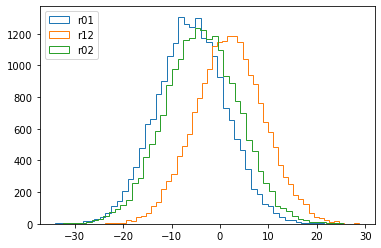

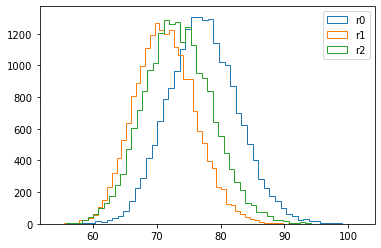

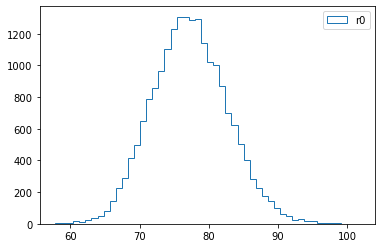

Mean, var:  77.16666666666667 11756.097054886486


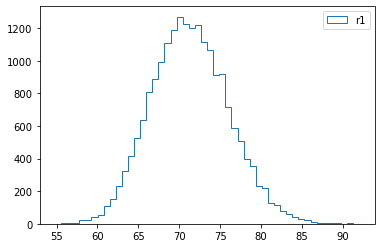

Mean, var:  71.33366583541147 9620.341368689635


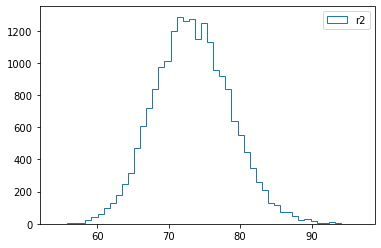

Mean, var:  73.23293373293373 10219.840680271012
mean 0-1:  -5.935937483358935
var 0-1:  51.54179752465772
Confidence 0-1:  0.20275
Confidence 0-2:  0.30915
Confidence 0-3:  0.0
Confidence 1-2:  0.60555
Confidence 1-3:  0.0
Confidence 2-3:  0.0


In [17]:
# Plot the bootstrap distribution diff distributions
plt.hist(r01, 50, label="r01", histtype = "step")
if n2 > 0: plt.hist(r12, 50, label="r12", histtype = "step")
if n2 > 0 and n3 > 0: plt.hist(r23, 50, label="r23", histtype = "step")
if n2 > 0: plt.hist(r02, 50, label="r02", histtype = "step")
if n3 > 0: plt.hist(r03, 50, label="r03", histtype = "step")
if n3 > 0: plt.hist(r13, 50, label="r13", histtype = "step")
plt.legend()
plt.show()

# Plot the iundividual bootstrap distributions
plt.hist(r0, 50, label="r0", histtype = "step")
plt.hist(r1, 50, label="r1", histtype = "step")
if n2 > 0: plt.hist(r2, 50, label="r2", histtype = "step")
if n3 > 0: plt.hist(r3, 50, label="r3", histtype = "step")
plt.legend()
plt.show()

# Create individual plots
plt.hist(r0, 50, label="r0", histtype = "step")
plt.legend()
plt.show()
print("Mean, var: ", mean0, var0)

plt.hist(r1, 50, label="r1", histtype = "step")
plt.legend()
plt.show()
print("Mean, var: ", mean1, var1)

if n2 > 0:
    plt.hist(r2, 50, label="r2", histtype = "step")
    plt.legend()
    plt.show()
    print("Mean, var: ", mean2, var2)

if n3 > 0:
    plt.hist(r3, 50, label="r3", histtype = "step")
    plt.legend()
    plt.show()
    print("Mean, var: ", mean3, var3)

# Calculate the distribution characteristics (based on maximum lilelihood for the normal distribution)
# This is done forf one random combinations
mean01 = np.average(r01)
var01 = np.average(r01 ** 2 - mean01 ** 2)

# Print results
print("mean 0-1: ", mean01)
print("var 0-1: ", var01)
print("Confidence 0-1: ", np.count_nonzero(r01[r01>0])/np.size(r01))
print("Confidence 0-2: ", np.count_nonzero(r02[r02>0])/np.size(r02))
print("Confidence 0-3: ", np.count_nonzero(r03[r03>0])/np.size(r03))
print("Confidence 1-2: ", np.count_nonzero(r12[r12>0])/np.size(r12))
print("Confidence 1-3: ", np.count_nonzero(r13[r13>0])/np.size(r13))
print("Confidence 2-3: ", np.count_nonzero(r23[r23>0])/np.size(r23))


In [18]:
# Bootstrap mean diff variances for all combonations
var01 = np.var(r01)
if n2 > 0: var02 = np.var(r02)
if n3 > 0: var03 = np.var(r03)
if n2 > 0: var12 = np.var(r12)
if n3 > 0: var13 = np.var(r13)
if n2 > 0 and n3 > 0: var23 = np.var(r23)

# Compare bootstrap theoretical mean diff variance to experimental
print("Group var 0,1,2 & 3: ", round(var0, 2), round(var1, 2), round(var2, 2), round(var3, 2))
print("Boot strap var 01, 02, 03, 12, 13 & 23: ", round(var01, 2), round(var02, 2), round(var03, 2), round(var12, 2), round(var13, 2), round(var23, 2))
print("Theoretical bs var: ", round((var0 + var1)/n0, 2), round((var0 + var2)/n0, 2), round((var0 + var3)/n0, 2), round((var1 + var2)/n0, 2), round((var1 + var3)/n0, 2), round((var2 + var3)/n0, 2))


Group var 0,1,2 & 3:  11756.1 9620.34 10219.84 0
Boot strap var 01, 02, 03, 12, 13 & 23:  51.54 58.0 0 51.07 0 0
Theoretical bs var:  52.78 54.26 29.03 48.99 23.75 25.23
